In [147]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import mean_squared_error

In [148]:
# Load and preprocess one image
image1 = np.array(Image.open('image2.png').convert('L')) / 255.0
images = image1.reshape(1, 28, 28, 1)  # Note the batch dimension is now 1

# Convert images to a TensorFlow tensor
images = tf.convert_to_tensor(images, dtype=tf.float32)


In [149]:
# Define the model architecture
model = tf.keras.Sequential([
    layers.Flatten(input_shape=(28, 28, 1)),
    layers.Dense(128, activation='relu'),
    layers.Dense(1024, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(5, activation='softmax')
])

In [150]:
# Compile and train the model on the single image
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
labels = np.array([1])  # dummy Label for the single image
model.fit(images, labels, epochs=10)  # Training on one image


Epoch 1/10
1/1 [==============================] - 2s 2s/step - loss: 1.6094 - accuracy: 0.0000e+00
Epoch 2/10
1/1 [==============================] - 0s 16ms/step - loss: 1.5747 - accuracy: 1.0000
Epoch 3/10
1/1 [==============================] - 0s 15ms/step - loss: 1.5379 - accuracy: 1.0000
Epoch 4/10
1/1 [==============================] - 0s 15ms/step - loss: 1.4987 - accuracy: 1.0000
Epoch 5/10
1/1 [==============================] - 0s 16ms/step - loss: 1.4571 - accuracy: 1.0000
Epoch 6/10
1/1 [==============================] - 0s 12ms/step - loss: 1.4130 - accuracy: 1.0000
Epoch 7/10
1/1 [==============================] - 0s 14ms/step - loss: 1.3664 - accuracy: 1.0000
Epoch 8/10
1/1 [==============================] - 0s 12ms/step - loss: 1.3174 - accuracy: 1.0000
Epoch 9/10
1/1 [==============================] - 0s 14ms/step - loss: 1.2662 - accuracy: 1.0000
Epoch 10/10
1/1 [==============================] - 0s 18ms/step - loss: 1.2128 - accuracy: 1.0000


In [151]:
# Calculate real gradients for the single image
with tf.GradientTape() as tape:
    tape.watch(images)
    predictions = model(images)
    loss = tf.keras.losses.sparse_categorical_crossentropy(labels, predictions)
real_gradients = tape.gradient(loss, model.trainable_variables)

In [152]:
# (remove comments to add the noise)
# Add Gaussian noise to the real gradients
# noise_stddev = 0.1  # Standard deviation of the Gaussian noise
# real_gradients = [g + tf.random.normal(g.shape, mean=0.0, stddev=noise_stddev) for g in real_gradients]

In [153]:
# Initialize dummy data and labels for one image
dummy_data = tf.Variable(np.random.normal(size=images.shape)*0.01 + 0.03, dtype=tf.float32, trainable=True)
dummy_labels = tf.Variable(np.random.uniform(0, 1, size=(1, 5)), dtype=tf.float32, trainable=True)


In [154]:
initial_learning_rate = 0.015
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=200, decay_rate=0.85, staircase=True)
optimizer = tf.optimizers.Adam(learning_rate=lr_schedule)

def compute_loss_and_grads(dummy_data, dummy_labels, real_gradients, model):

    grad_diff = 0

    with tf.GradientTape(persistent=True) as tape:
        tape.watch([dummy_data, dummy_labels])
        dummy_predictions = model(dummy_data)
        dummy_loss = tf.keras.losses.categorical_crossentropy(tf.nn.softmax(dummy_labels), dummy_predictions)

        dummy_gradients = tape.gradient(dummy_loss, model.trainable_variables)
        if dummy_gradients is None or any(g is None for g in dummy_gradients):
            print("Dummy gradients computation failed.")
            return None, (None, None)

        grad_diff = tf.add_n([tf.norm(rg - dg) if rg is not None and dg is not None else 0 for rg, dg in zip(real_gradients, dummy_gradients)])

        dummy_data_grads = tape.gradient(grad_diff, dummy_data)
        dummy_label_grads = tape.gradient(grad_diff, dummy_labels)

    #  Clean up tape after use
    del tape

    if dummy_data_grads is None or dummy_label_grads is None:
        print("Gradient computation for dummy data/labels failed.")
        return grad_diff, (None, None)

    return grad_diff, (dummy_data_grads, dummy_label_grads)

# Adjust the optimization loop
clip_value = 1.0
for step in range(1000):
    result = compute_loss_and_grads(dummy_data, dummy_labels, real_gradients, model)
    if result is None:
        print(f"Failed to compute gradients at step {step}")
        continue

    grad_diff, (dummy_data_grads, dummy_label_grads) = result
    if dummy_data_grads is not None and dummy_label_grads is not None:
        dummy_data_grads = [tf.clip_by_norm(g, clip_value) for g in dummy_data_grads]
        dummy_label_grads = [tf.clip_by_norm(g, clip_value) for g in dummy_label_grads]
        optimizer.apply_gradients([(dummy_data_grads, dummy_data), (dummy_label_grads, dummy_labels)])
    else:
        print("Invalid gradients; skipping update at step", step)

    if step % 50 == 0:
      print(f"Step {step}, Gradient Difference: {grad_diff.numpy()}" if grad_diff is not None else "Gradient diff computation failed.")




Step 0, Gradient Difference: 23.050504684448242
Step 50, Gradient Difference: 20.29650115966797
Step 100, Gradient Difference: 19.362314224243164
Step 150, Gradient Difference: 15.83189582824707
Step 200, Gradient Difference: 14.44100284576416
Step 250, Gradient Difference: 14.213375091552734
Step 300, Gradient Difference: 13.038057327270508
Step 350, Gradient Difference: 12.311405181884766
Step 400, Gradient Difference: 11.684813499450684
Step 450, Gradient Difference: 11.344088554382324
Step 500, Gradient Difference: 10.602599143981934
Step 550, Gradient Difference: 10.376317977905273
Step 600, Gradient Difference: 10.298962593078613
Step 650, Gradient Difference: 10.177754402160645
Step 700, Gradient Difference: 9.230910301208496
Step 750, Gradient Difference: 9.336532592773438
Step 800, Gradient Difference: 9.267695426940918
Step 850, Gradient Difference: 9.338908195495605
Step 900, Gradient Difference: 9.24230670928955
Step 950, Gradient Difference: 8.951207160949707


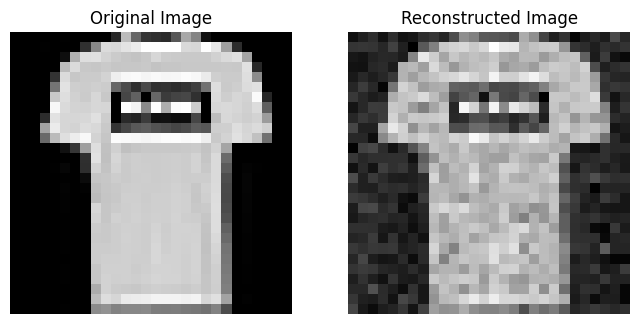

In [155]:
# Visualize the results - showing both original and reconstructed images
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

images_np = images.numpy()

# Display the original image
axes[0].imshow(images_np[0].reshape(28, 28), cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

# Display the reconstructed image
axes[1].imshow(dummy_data[0].numpy().reshape(28, 28), cmap='gray')
axes[1].set_title('Reconstructed Image')
axes[1].axis('off')

plt.show()

In [156]:
reconstructed_image = dummy_data[0].numpy()
mse = mean_squared_error(images_np.flatten(), reconstructed_image.flatten())
print(f'Mean Squared Error (MSE) between original and reconstructed image: {mse}')

Mean Squared Error (MSE) between original and reconstructed image: 2.818610906600952
